# Supervised Learning of Drug Response using CORES from Copy Number Log Ratio

### Import Python source code

In [33]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 26 12:21:38 2018

@author: bbece
"""

from __future__ import division, print_function, unicode_literals
import numpy as np
import os
from IPython.display import display, HTML

from pprint import pprint
np.random.seed(42)

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
            
import pandas as pd
import scipy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

from sklearn import decomposition

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.tree import export_graphviz

import math



### Define method to split training and testing set

In [174]:
# TODO: Manipulate test_ratio
def split_train_test(training_set, test_ratio = 0.33):
    row_count = training_set.shape[0]
    shuffled_indices = np.random.permutation(row_count)
    test_set_size = int(test_ratio * row_count)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return training_set.iloc[train_indices], training_set.iloc[test_indices]

### Load training set matrix

In [177]:
labeled_matrix_training_set = pd.read_csv("../mlOutput/coreTrainingSet_7_31_2018_1.csv")
#labeled_matrix_training_set.columns.values[0] = "sampleId"
labeled_matrix_training_set = labeled_matrix_training_set.drop([labeled_matrix_training_set.columns[0]], axis = 1)
labels = list(range(0,5))


In [178]:
display(labeled_matrix_training_set.head(25))

,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin,1,4,6,8,9,...,43,44,45,46,47,48,49,50,52,53
0,0.637520,0.652945,0.679371,0.822522,0.927028,-0.191476,-0.111982,-0.031535,0.194702,0.109698,...,-0.180308,-0.388883,-0.254426,-0.132726,-0.228261,0.044768,0.090468,0.614185,0.673407,-0.860605
1,0.744417,0.667870,0.563638,0.839585,0.874489,0.117598,0.049725,0.292631,-0.521739,-0.523807,...,0.126315,-0.115778,-0.407217,0.393595,0.052298,0.333852,0.468704,-0.387182,0.542903,-0.110980
2,0.736595,0.697379,0.606223,0.909020,0.939280,-0.516071,-0.485236,0.178861,-0.645285,-0.570933,...,0.096073,-0.113105,-0.542922,0.354936,-0.478933,0.325882,0.367046,-0.324453,0.568131,-0.058653
3,0.672706,0.631027,0.590799,0.641945,0.924407,-0.494288,-0.585292,0.200625,-0.543859,-0.550807,...,-0.012848,-0.207628,0.007515,0.405350,-0.026541,0.686015,0.892808,-1.248245,0.162810,-0.071772
4,0.585682,0.614227,0.579178,0.583491,NaN,-0.548347,-0.512629,0.188757,-0.508282,-0.553873,...,0.105863,-0.005723,-0.486995,0.389744,-0.490257,0.341218,0.439575,-0.359887,0.544827,-0.097471
5,0.594934,0.555007,0.577066,0.655291,0.797361,-0.152207,-0.232395,0.017240,0.090808,0.594028,...,-0.051265,-0.982253,-0.722570,0.101296,-0.701480,0.399766,0.568611,-1.265804,-0.727523,-0.840313
6,0.703385,0.716384,0.622144,0.686940,0.755721,-0.865086,-0.839420,0.063100,1.017900,0.767024,...,0.047438,-1.078818,-0.244171,-0.729638,-0.165546,0.696704,0.726559,-0.631101,-0.176888,-1.077671
7,0.719214,0.706000,0.685489,0.833724,0.858955,-0.449552,-0.292191,-0.226701,1.289295,0.528855,...,0.115252,-0.519968,-0.366583,-0.308246,-0.316218,0.368994,0.616677,-0.981539,-0.336687,-1.463251
8,0.659406,0.645487,0.632628,0.840813,0.780229,-0.031180,-0.153512,0.093899,-0.079696,-0.071165,...,0.017210,-0.090001,-0.039323,0.247772,-0.920805,0.035799,0.242064,0.727594,0.715756,-0.120640
9,0.588977,0.574002,0.610205,0.692301,0.884302,-0.375885,-0.477392,-0.698400,-0.005437,-0.177461,...,0.056420,0.151259,0.123738,0.261639,-0.356099,0.650798,0.793634,-0.745894,0.324992,-0.490552


In [179]:
X = labeled_matrix_training_set.copy().drop(labeled_matrix_training_set.columns[labels], axis = 1)
y = labeled_matrix_training_set.copy()[labeled_matrix_training_set.columns[labels]]

In [180]:
display(X.head())

,1,4,6,8,9,10,18,26,28,29,...,43,44,45,46,47,48,49,50,52,53
0,-0.191476,-0.111982,-0.031535,0.194702,0.109698,0.003998,0.119656,0.156530,0.251035,-0.118935,...,-0.180308,-0.388883,-0.254426,-0.132726,-0.228261,0.044768,0.090468,0.614185,0.673407,-0.860605
1,0.117598,0.049725,0.292631,-0.521739,-0.523807,0.544235,0.383965,0.165220,0.114869,0.131417,...,0.126315,-0.115778,-0.407217,0.393595,0.052298,0.333852,0.468704,-0.387182,0.542903,-0.110980
2,-0.516071,-0.485236,0.178861,-0.645285,-0.570933,0.637539,0.410054,-0.315922,-0.421444,0.106407,...,0.096073,-0.113105,-0.542922,0.354936,-0.478933,0.325882,0.367046,-0.324453,0.568131,-0.058653
3,-0.494288,-0.585292,0.200625,-0.543859,-0.550807,0.602352,0.362455,0.152620,0.105762,0.047702,...,-0.012848,-0.207628,0.007515,0.405350,-0.026541,0.686015,0.892808,-1.248245,0.162810,-0.071772
4,-0.548347,-0.512629,0.188757,-0.508282,-0.553873,0.629993,0.340205,-0.345301,-0.423682,0.034815,...,0.105863,-0.005723,-0.486995,0.389744,-0.490257,0.341218,0.439575,-0.359887,0.544827,-0.097471


In [198]:
display(y.head(15))

,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin
0,0.637520,0.652945,0.679371,0.822522,0.927028
1,0.744417,0.667870,0.563638,0.839585,0.874489
2,0.736595,0.697379,0.606223,0.909020,0.939280
3,0.672706,0.631027,0.590799,0.641945,0.924407
4,0.585682,0.614227,0.579178,0.583491,NaN
5,0.594934,0.555007,0.577066,0.655291,0.797361
6,0.703385,0.716384,0.622144,0.686940,0.755721
7,0.719214,0.706000,0.685489,0.833724,0.858955
8,0.659406,0.645487,0.632628,0.840813,0.780229
9,0.588977,0.574002,0.610205,0.692301,0.884302


In [200]:
from sklearn.model_selection import train_test_split

all_X_TRAIN, all_X_TEST, all_Y_TRAIN, all_Y_TEST = train_test_split(X, y, test_size=0.20, random_state=42)
# TODO: train_test must be split on amount of NAs as well!

In [201]:
display(all_X_TRAIN.head())
display(all_Y_TRAIN.head())

,1,4,6,8,9,10,18,26,28,29,...,43,44,45,46,47,48,49,50,52,53
3,-0.494288,-0.585292,0.200625,-0.543859,-0.550807,0.602352,0.362455,0.152620,0.105762,0.047702,...,-0.012848,-0.207628,0.007515,0.405350,-0.026541,0.686015,0.892808,-1.248245,0.162810,-0.071772
33,-0.661236,-0.657760,0.235469,0.072571,-0.159201,0.097861,0.343506,-0.853388,0.291893,0.131713,...,0.135366,-0.134136,0.136543,-0.029101,0.066422,0.817173,0.915590,-0.594891,0.545486,-0.920124
34,-0.068917,-0.112021,0.131232,0.017845,-0.129364,0.271154,0.269498,0.077794,0.000711,-0.052039,...,-0.010096,-0.273115,-0.024468,-0.142772,-0.066913,0.248184,0.257082,0.162451,0.126015,-0.156141
8,-0.031180,-0.153512,0.093899,-0.079696,-0.071165,0.345770,0.251604,-0.068857,-0.031771,0.034095,...,0.017210,-0.090001,-0.039323,0.247772,-0.920805,0.035799,0.242064,0.727594,0.715756,-0.120640
17,-0.055799,-0.027714,0.119105,-0.101909,-0.071291,0.252327,0.173155,-0.071644,-0.042190,0.030786,...,0.006451,-0.113787,-0.069329,-0.158435,0.002658,0.151468,0.275130,0.213884,0.189410,-0.165871


,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin
3,0.672706,0.631027,0.590799,0.641945,0.924407
33,0.628506,0.538041,0.581497,0.696855,0.703624
34,NaN,NaN,NaN,NaN,NaN
8,0.659406,0.645487,0.632628,0.840813,0.780229
17,NaN,NaN,NaN,NaN,NaN


In [202]:
display(all_X_TEST.head())
display(all_Y_TEST.head())

,1,4,6,8,9,10,18,26,28,29,...,43,44,45,46,47,48,49,50,52,53
31,-0.793647,-0.733394,-0.577410,0.131569,0.173874,0.508716,0.358452,-0.538476,-0.545914,0.045181,...,-0.498442,-0.013938,0.098197,0.044226,0.153715,0.607891,0.504616,-0.547103,0.266265,-0.871054
5,-0.152207,-0.232395,0.017240,0.090808,0.594028,0.250321,0.542556,1.071464,-0.115415,-0.197146,...,-0.051265,-0.982253,-0.722570,0.101296,-0.701480,0.399766,0.568611,-1.265804,-0.727523,-0.840313
32,-0.292889,-0.282393,0.263494,0.936464,-0.367825,0.502159,-0.044175,0.183044,0.217955,0.247878,...,-0.280216,-0.355018,-0.311647,0.018024,-0.301959,0.755412,0.965802,-0.152294,0.737134,-0.305370
13,-0.094289,-0.141520,0.159971,-0.165156,-0.110761,0.349261,0.281028,0.028566,-0.023635,-0.076143,...,-0.030972,-0.308203,-0.173855,-0.621950,-0.056215,0.260743,0.450450,0.168904,0.128771,-0.216011
19,-0.029940,-0.043098,0.133945,-0.098645,-0.083363,0.225117,0.283605,0.002719,-0.022981,-0.027317,...,-0.014912,-0.111417,-0.075827,0.200881,-0.059174,0.232297,0.344084,0.112751,0.161177,-0.179714


,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin
31,0.790540,0.826007,0.814614,0.875244,0.838208
5,0.594934,0.555007,0.577066,0.655291,0.797361
32,0.626015,0.616177,0.548900,0.794304,0.914314
13,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN


## Visualize ML Results

In [169]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [237]:
def retrieve_pipelines(model_name, ml_model):
    Ypipeline = Pipeline([
     ('imputer', Imputer(axis=0,strategy="median")),
     ('standardizer', StandardScaler()),
    ])

    XYpipeline = Pipeline([
            ('imputer', Imputer(axis=0,strategy="median")),
            ('standardizer', StandardScaler()),
            (model_name,  ml_model)
    ])
    
    return (Ypipeline, XYpipeline)

def imputer_inverse_transform(pre_data, post_data):
    na_indices = np.where(np.isnan(pre_data))[0]
    post_data[na_indices] = float('NaN')
    return post_data
    
def remove_NAs(X, y, label):
    label_y = y[[y.columns[label]]]
    na_indices = label_y[label_y.columns[0]].index[label_y[label_y.columns[0]].apply(np.isnan)]
    y_nonNA = label_y.copy().drop(na_indices)
    X_nonNA = X.copy().drop(na_indices)
    return X_nonNA, y_nonNA
    
def train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, this_y_train, this_y_test):
    this_y_train_tr = Ypipeline.fit_transform(this_y_train)
    XYpipeline.fit(X_TRAIN,this_y_train_tr)

    y_test_tr = Ypipeline.transform(this_y_test)
    y_prediction = XYpipeline.predict(X_TEST)

    y_prediction = Ypipeline.named_steps['standardizer'].inverse_transform(y_prediction)
    y_prediction = imputer_inverse_transform(this_y_test, y_prediction)

    y_test_np = this_y_test
    y_test_np = y_test_np[~np.isnan(y_test_np)]
    y_prediction = y_prediction[~np.isnan(y_prediction)]
    return (y_test_np, y_prediction, this_y_train_tr)


def simple_score(y_test_np, y_prediction):
    rmse = np.sqrt(mean_squared_error(y_test_np, y_prediction))
    r = scipy.stats.pearsonr(y_test_np, y_prediction)
    t = scipy.stats.spearmanr(y_test_np, y_prediction)
    return (rmse, r, t)
    
def visualize(y_test_np, y_prediction):
    plt.plot(y_test_np, y_prediction, 'bo')
    abline(1,0)
    plt.ylabel("Prediction")
    plt.xlabel("Label")
    plt.show()
    
def display_set(X_TRAIN, X_TEST, Y_TRAIN, Y_TEST):
    TRAIN = pd.concat([Y_TRAIN, X_TRAIN], axis=1)
    TEST = pd.concat([Y_TEST, X_TEST], axis=1)
    pprint("TRAIN")
    display(TRAIN)
    pprint("TEST")
    display(TEST)

def cv_score(XYpipeline, X_TRAIN, this_y_train_tr):
    scores = cross_val_score(XYpipeline, X_TRAIN, this_y_train_tr,
                             scoring = "neg_mean_squared_error", cv=10)
    scores = Ypipeline.named_steps['standardizer'].inverse_transform(scores)
    return scores


### Visualize ML results using Linear Regression

'TRAIN'


,Gemcitabine,1,4,6,8,9,10,18,26,28,...,43,44,45,46,47,48,49,50,52,53
31,0.790540,-0.793647,-0.733394,-0.577410,0.131569,0.173874,0.508716,0.358452,-0.538476,-0.545914,...,-0.498442,-0.013938,0.098197,0.044226,0.153715,0.607891,0.504616,-0.547103,0.266265,-0.871054
5,0.594934,-0.152207,-0.232395,0.017240,0.090808,0.594028,0.250321,0.542556,1.071464,-0.115415,...,-0.051265,-0.982253,-0.722570,0.101296,-0.701480,0.399766,0.568611,-1.265804,-0.727523,-0.840313
10,0.616641,-0.041911,-0.105199,0.158690,-0.022572,-0.118414,0.336608,0.296398,0.076242,0.027292,...,0.043518,-1.010451,-0.996984,-0.244253,-0.932011,0.277337,0.302895,0.157189,0.180116,-0.885793
28,0.721390,0.100842,0.176792,0.286407,-0.500770,-0.515221,-0.057958,-0.161896,0.816140,0.772741,...,0.114698,-0.030854,0.048133,0.117603,0.046509,0.413547,0.446485,-0.260582,0.112955,-0.607816
30,0.636072,-0.142605,-0.314467,-0.054921,-0.872900,-0.781188,0.600398,0.475794,0.177194,0.158062,...,0.094297,-0.301327,-0.127216,-0.056325,-0.154649,0.277617,0.508344,-0.670705,0.266432,-0.610304
33,0.628506,-0.661236,-0.657760,0.235469,0.072571,-0.159201,0.097861,0.343506,-0.853388,0.291893,...,0.135366,-0.134136,0.136543,-0.029101,0.066422,0.817173,0.915590,-0.594891,0.545486,-0.920124
23,0.736810,-0.459061,-0.470274,0.149253,-0.115348,0.355631,-0.046983,0.798941,-0.386431,-0.434430,...,-0.448763,-0.711446,-0.649702,-0.309415,-0.550822,-0.206520,-0.121337,0.931852,0.885218,-0.717596
32,0.626015,-0.292889,-0.282393,0.263494,0.936464,-0.367825,0.502159,-0.044175,0.183044,0.217955,...,-0.280216,-0.355018,-0.311647,0.018024,-0.301959,0.755412,0.965802,-0.152294,0.737134,-0.305370
11,0.537925,-0.254319,-0.314949,0.120570,-0.101179,0.013621,-0.299450,0.565517,0.229382,0.290038,...,-0.216381,-1.642832,0.031561,0.028808,0.105595,0.361892,0.662162,-0.441893,-0.503256,-0.778165
9,0.588977,-0.375885,-0.477392,-0.698400,-0.005437,-0.177461,0.358437,0.324040,-0.366013,-0.328785,...,0.056420,0.151259,0.123738,0.261639,-0.356099,0.650798,0.793634,-0.745894,0.324992,-0.490552


'TEST'


,Gemcitabine,1,4,6,8,9,10,18,26,28,...,43,44,45,46,47,48,49,50,52,53
12,0.645679,-0.630500,-0.573515,0.092297,0.278194,-0.078141,0.649611,0.224325,-0.245483,-0.180274,...,-0.164235,-0.559933,0.368464,0.260209,-0.558487,0.542000,0.657271,0.552537,0.560688,-0.907621
27,0.650505,0.188480,0.005245,-0.128250,0.386500,-0.021539,-0.315933,0.445162,0.192573,0.157855,...,-0.173763,0.035426,0.113798,-0.007964,-0.479805,0.533104,0.536431,-0.613951,0.321583,-0.935108
3,0.672706,-0.494288,-0.585292,0.200625,-0.543859,-0.550807,0.602352,0.362455,0.152620,0.105762,...,-0.012848,-0.207628,0.007515,0.405350,-0.026541,0.686015,0.892808,-1.248245,0.162810,-0.071772
48,0.777284,0.088936,-0.046715,0.288028,0.078507,0.041986,0.577174,-0.352621,0.789425,-0.595836,...,0.160846,-0.754018,-0.796073,0.056137,-0.689558,0.234045,0.594899,0.145936,0.176360,-0.872517
6,0.703385,-0.865086,-0.839420,0.063100,1.017900,0.767024,0.350421,0.702739,0.903873,-0.291576,...,0.047438,-1.078818,-0.244171,-0.729638,-0.165546,0.696704,0.726559,-0.631101,-0.176888,-1.077671
0,0.637520,-0.191476,-0.111982,-0.031535,0.194702,0.109698,0.003998,0.119656,0.156530,0.251035,...,-0.180308,-0.388883,-0.254426,-0.132726,-0.228261,0.044768,0.090468,0.614185,0.673407,-0.860605
2,0.736595,-0.516071,-0.485236,0.178861,-0.645285,-0.570933,0.637539,0.410054,-0.315922,-0.421444,...,0.096073,-0.113105,-0.542922,0.354936,-0.478933,0.325882,0.367046,-0.324453,0.568131,-0.058653
41,0.774171,-0.230522,-0.308004,-0.456408,-0.188917,0.259390,0.197161,0.055987,0.244007,-0.135973,...,0.418812,-0.201626,-0.055673,0.208578,-0.083814,0.397680,0.308472,-0.202924,0.322068,-0.705301


array([], dtype=int64)
RMSE: 0.0959554598619
Pearson: (-0.068643005600387483, 0.87169808848465269)
Spearman: SpearmanrResult(correlation=-0.095238095238095261, pvalue=0.82250543020361144)


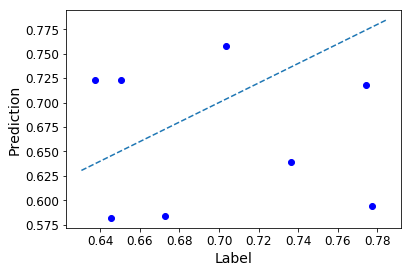

'TRAIN'


,Paclitaxel,1,4,6,8,9,10,18,26,28,...,43,44,45,46,47,48,49,50,52,53
6,0.716384,-0.865086,-0.839420,0.063100,1.017900,0.767024,0.350421,0.702739,0.903873,-0.291576,...,0.047438,-1.078818,-0.244171,-0.729638,-0.165546,0.696704,0.726559,-0.631101,-0.176888,-1.077671
23,0.685397,-0.459061,-0.470274,0.149253,-0.115348,0.355631,-0.046983,0.798941,-0.386431,-0.434430,...,-0.448763,-0.711446,-0.649702,-0.309415,-0.550822,-0.206520,-0.121337,0.931852,0.885218,-0.717596
30,0.567934,-0.142605,-0.314467,-0.054921,-0.872900,-0.781188,0.600398,0.475794,0.177194,0.158062,...,0.094297,-0.301327,-0.127216,-0.056325,-0.154649,0.277617,0.508344,-0.670705,0.266432,-0.610304
50,0.565054,0.029385,-0.045247,0.173001,-0.065459,-0.053373,0.402152,0.258128,0.086468,0.045436,...,0.097589,-0.155218,-0.001989,-0.035146,-0.859525,0.346353,0.392147,-0.669184,0.126944,-0.139881
16,0.545283,0.069205,-0.100637,0.231349,-0.121998,-0.077860,0.563741,0.374175,-0.770149,-0.829023,...,-0.402500,-0.106846,-0.010322,-0.059411,-0.044529,0.313438,0.491236,0.135857,0.180003,-1.132962
32,0.616177,-0.292889,-0.282393,0.263494,0.936464,-0.367825,0.502159,-0.044175,0.183044,0.217955,...,-0.280216,-0.355018,-0.311647,0.018024,-0.301959,0.755412,0.965802,-0.152294,0.737134,-0.305370
31,0.826007,-0.793647,-0.733394,-0.577410,0.131569,0.173874,0.508716,0.358452,-0.538476,-0.545914,...,-0.498442,-0.013938,0.098197,0.044226,0.153715,0.607891,0.504616,-0.547103,0.266265,-0.871054
29,0.585097,-0.064291,0.008584,0.135002,0.002919,-0.987501,0.361297,0.257853,0.043798,0.022232,...,0.070613,0.356154,0.523368,0.375216,-0.922260,0.345536,0.247239,-0.338829,0.203672,-0.188640
10,0.575363,-0.041911,-0.105199,0.158690,-0.022572,-0.118414,0.336608,0.296398,0.076242,0.027292,...,0.043518,-1.010451,-0.996984,-0.244253,-0.932011,0.277337,0.302895,0.157189,0.180116,-0.885793
1,0.667870,0.117598,0.049725,0.292631,-0.521739,-0.523807,0.544235,0.383965,0.165220,0.114869,...,0.126315,-0.115778,-0.407217,0.393595,0.052298,0.333852,0.468704,-0.387182,0.542903,-0.110980


'TEST'


,Paclitaxel,1,4,6,8,9,10,18,26,28,...,43,44,45,46,47,48,49,50,52,53
48,0.745540,0.088936,-0.046715,0.288028,0.078507,0.041986,0.577174,-0.352621,0.789425,-0.595836,...,0.160846,-0.754018,-0.796073,0.056137,-0.689558,0.234045,0.594899,0.145936,0.176360,-0.872517
46,0.675574,-0.132991,-0.052921,0.159445,0.455027,-0.089800,0.279075,0.183969,-0.065135,-0.069582,...,-0.009625,-1.046767,-0.962740,-0.198716,-0.983554,0.260043,0.295669,0.130036,0.109968,-0.250841
8,0.645487,-0.031180,-0.153512,0.093899,-0.079696,-0.071165,0.345770,0.251604,-0.068857,-0.031771,...,0.017210,-0.090001,-0.039323,0.247772,-0.920805,0.035799,0.242064,0.727594,0.715756,-0.120640
26,0.588074,0.062524,0.046054,0.230612,-0.296368,-0.423706,0.549676,0.409402,0.184092,0.724945,...,0.128059,-0.823991,-0.939748,-0.186776,-0.838846,0.362982,0.464413,0.011212,-0.541660,-1.027032
20,0.586244,-0.621311,-0.694679,0.410747,0.128349,0.157904,-0.253223,0.165145,0.340186,0.673163,...,0.005222,0.091789,0.242627,0.404049,0.218238,0.536810,1.076009,-0.537738,0.239328,-1.724291
4,0.614227,-0.548347,-0.512629,0.188757,-0.508282,-0.553873,0.629993,0.340205,-0.345301,-0.423682,...,0.105863,-0.005723,-0.486995,0.389744,-0.490257,0.341218,0.439575,-0.359887,0.544827,-0.097471
11,0.561322,-0.254319,-0.314949,0.120570,-0.101179,0.013621,-0.299450,0.565517,0.229382,0.290038,...,-0.216381,-1.642832,0.031561,0.028808,0.105595,0.361892,0.662162,-0.441893,-0.503256,-0.778165
27,0.518664,0.188480,0.005245,-0.128250,0.386500,-0.021539,-0.315933,0.445162,0.192573,0.157855,...,-0.173763,0.035426,0.113798,-0.007964,-0.479805,0.533104,0.536431,-0.613951,0.321583,-0.935108


array([], dtype=int64)
RMSE: 0.119330156285
Pearson: (0.065369296302662638, 0.87778128741577122)
Spearman: SpearmanrResult(correlation=0.04761904761904763, pvalue=0.91084916851958364)


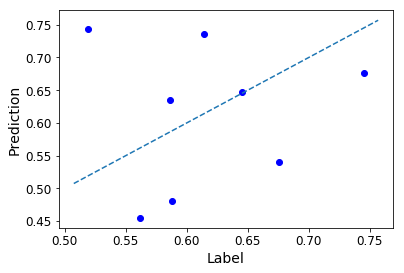

'TRAIN'


,SN-38,1,4,6,8,9,10,18,26,28,...,43,44,45,46,47,48,49,50,52,53
23,0.583725,-0.459061,-0.470274,0.149253,-0.115348,0.355631,-0.046983,0.798941,-0.386431,-0.434430,...,-0.448763,-0.711446,-0.649702,-0.309415,-0.550822,-0.206520,-0.121337,0.931852,0.885218,-0.717596
27,0.568507,0.188480,0.005245,-0.128250,0.386500,-0.021539,-0.315933,0.445162,0.192573,0.157855,...,-0.173763,0.035426,0.113798,-0.007964,-0.479805,0.533104,0.536431,-0.613951,0.321583,-0.935108
30,0.549987,-0.142605,-0.314467,-0.054921,-0.872900,-0.781188,0.600398,0.475794,0.177194,0.158062,...,0.094297,-0.301327,-0.127216,-0.056325,-0.154649,0.277617,0.508344,-0.670705,0.266432,-0.610304
29,0.554903,-0.064291,0.008584,0.135002,0.002919,-0.987501,0.361297,0.257853,0.043798,0.022232,...,0.070613,0.356154,0.523368,0.375216,-0.922260,0.345536,0.247239,-0.338829,0.203672,-0.188640
4,0.579178,-0.548347,-0.512629,0.188757,-0.508282,-0.553873,0.629993,0.340205,-0.345301,-0.423682,...,0.105863,-0.005723,-0.486995,0.389744,-0.490257,0.341218,0.439575,-0.359887,0.544827,-0.097471
49,0.586283,-0.099292,-0.049921,0.093903,-0.122174,-0.037728,0.383120,0.245096,-0.558097,-0.651007,...,0.027843,-1.216677,-0.156719,-0.221017,-0.096230,0.070726,0.387022,0.176322,0.393235,-0.085440
50,0.610227,0.029385,-0.045247,0.173001,-0.065459,-0.053373,0.402152,0.258128,0.086468,0.045436,...,0.097589,-0.155218,-0.001989,-0.035146,-0.859525,0.346353,0.392147,-0.669184,0.126944,-0.139881
28,0.602269,0.100842,0.176792,0.286407,-0.500770,-0.515221,-0.057958,-0.161896,0.816140,0.772741,...,0.114698,-0.030854,0.048133,0.117603,0.046509,0.413547,0.446485,-0.260582,0.112955,-0.607816
41,0.635591,-0.230522,-0.308004,-0.456408,-0.188917,0.259390,0.197161,0.055987,0.244007,-0.135973,...,0.418812,-0.201626,-0.055673,0.208578,-0.083814,0.397680,0.308472,-0.202924,0.322068,-0.705301
54,0.530075,0.045642,-0.049498,-0.612778,-0.857374,-0.128921,-0.433573,0.446114,0.832755,0.735107,...,-0.049674,-0.375108,-0.036024,0.155403,-0.031953,0.412994,0.464774,-0.778031,0.099411,-1.069674


'TEST'


,SN-38,1,4,6,8,9,10,18,26,28,...,43,44,45,46,47,48,49,50,52,53
16,0.489531,0.069205,-0.100637,0.231349,-0.121998,-0.077860,0.563741,0.374175,-0.770149,-0.829023,...,-0.402500,-0.106846,-0.010322,-0.059411,-0.044529,0.313438,0.491236,0.135857,0.180003,-1.132962
14,0.564607,0.081332,-0.054980,-0.070272,-1.143911,-0.040811,0.573311,0.365629,-0.255211,-0.339361,...,-0.238737,-0.401886,-0.115039,-0.541325,-0.351988,0.660885,0.782228,-0.183996,-0.123555,-0.154656
15,0.735381,0.052958,-0.064011,0.186196,0.459753,0.011592,0.412557,0.333086,0.031534,-0.025089,...,0.104651,0.406496,0.665337,-0.620469,-0.882895,0.249471,0.392494,-0.825713,0.201539,-0.804902
10,0.557068,-0.041911,-0.105199,0.158690,-0.022572,-0.118414,0.336608,0.296398,0.076242,0.027292,...,0.043518,-1.010451,-0.996984,-0.244253,-0.932011,0.277337,0.302895,0.157189,0.180116,-0.885793
20,0.558598,-0.621311,-0.694679,0.410747,0.128349,0.157904,-0.253223,0.165145,0.340186,0.673163,...,0.005222,0.091789,0.242627,0.404049,0.218238,0.536810,1.076009,-0.537738,0.239328,-1.724291
2,0.606223,-0.516071,-0.485236,0.178861,-0.645285,-0.570933,0.637539,0.410054,-0.315922,-0.421444,...,0.096073,-0.113105,-0.542922,0.354936,-0.478933,0.325882,0.367046,-0.324453,0.568131,-0.058653
5,0.577066,-0.152207,-0.232395,0.017240,0.090808,0.594028,0.250321,0.542556,1.071464,-0.115415,...,-0.051265,-0.982253,-0.722570,0.101296,-0.701480,0.399766,0.568611,-1.265804,-0.727523,-0.840313
48,0.701093,0.088936,-0.046715,0.288028,0.078507,0.041986,0.577174,-0.352621,0.789425,-0.595836,...,0.160846,-0.754018,-0.796073,0.056137,-0.689558,0.234045,0.594899,0.145936,0.176360,-0.872517


array([], dtype=int64)
RMSE: 0.100198543831
Pearson: (-0.09925612607394059, 0.8151134627469474)
Spearman: SpearmanrResult(correlation=-0.04761904761904763, pvalue=0.91084916851958364)


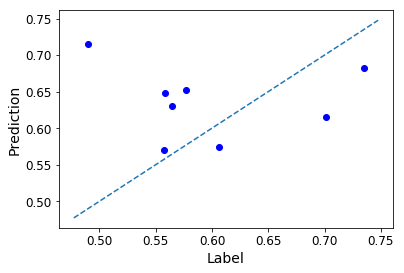

'TRAIN'


,5-FU,1,4,6,8,9,10,18,26,28,...,43,44,45,46,47,48,49,50,52,53
45,0.615629,-0.553356,-0.626908,0.254959,-0.440423,-0.535674,-0.103523,0.687648,0.036670,0.068482,...,-0.278365,-0.654158,-0.505110,-0.527062,-0.475028,0.744480,0.768278,-1.050224,0.290126,-0.704034
12,0.942370,-0.630500,-0.573515,0.092297,0.278194,-0.078141,0.649611,0.224325,-0.245483,-0.180274,...,-0.164235,-0.559933,0.368464,0.260209,-0.558487,0.542000,0.657271,0.552537,0.560688,-0.907621
14,0.799785,0.081332,-0.054980,-0.070272,-1.143911,-0.040811,0.573311,0.365629,-0.255211,-0.339361,...,-0.238737,-0.401886,-0.115039,-0.541325,-0.351988,0.660885,0.782228,-0.183996,-0.123555,-0.154656
1,0.839585,0.117598,0.049725,0.292631,-0.521739,-0.523807,0.544235,0.383965,0.165220,0.114869,...,0.126315,-0.115778,-0.407217,0.393595,0.052298,0.333852,0.468704,-0.387182,0.542903,-0.110980
24,0.881464,-0.016205,0.010176,0.196368,0.040452,0.012000,0.358982,0.097246,0.033353,0.047589,...,0.099536,-0.002248,0.068053,0.239143,0.073498,0.405691,0.383866,-0.728602,0.406252,-0.257473
7,0.833724,-0.449552,-0.292191,-0.226701,1.289295,0.528855,-0.092931,0.633048,1.162489,0.196713,...,0.115252,-0.519968,-0.366583,-0.308246,-0.316218,0.368994,0.616677,-0.981539,-0.336687,-1.463251
43,0.836726,-0.179435,-0.093792,0.181812,0.037107,-0.077954,0.433984,0.247703,0.105836,-0.014121,...,0.005119,-0.365865,-0.190448,0.269640,-0.133813,0.179332,0.194316,0.024681,0.232569,-0.309794
30,0.762266,-0.142605,-0.314467,-0.054921,-0.872900,-0.781188,0.600398,0.475794,0.177194,0.158062,...,0.094297,-0.301327,-0.127216,-0.056325,-0.154649,0.277617,0.508344,-0.670705,0.266432,-0.610304
26,0.898595,0.062524,0.046054,0.230612,-0.296368,-0.423706,0.549676,0.409402,0.184092,0.724945,...,0.128059,-0.823991,-0.939748,-0.186776,-0.838846,0.362982,0.464413,0.011212,-0.541660,-1.027032
33,0.696855,-0.661236,-0.657760,0.235469,0.072571,-0.159201,0.097861,0.343506,-0.853388,0.291893,...,0.135366,-0.134136,0.136543,-0.029101,0.066422,0.817173,0.915590,-0.594891,0.545486,-0.920124


'TEST'


,5-FU,1,4,6,8,9,10,18,26,28,...,43,44,45,46,47,48,49,50,52,53
31,0.875244,-0.793647,-0.733394,-0.577410,0.131569,0.173874,0.508716,0.358452,-0.538476,-0.545914,...,-0.498442,-0.013938,0.098197,0.044226,0.153715,0.607891,0.504616,-0.547103,0.266265,-0.871054
6,0.686940,-0.865086,-0.839420,0.063100,1.017900,0.767024,0.350421,0.702739,0.903873,-0.291576,...,0.047438,-1.078818,-0.244171,-0.729638,-0.165546,0.696704,0.726559,-0.631101,-0.176888,-1.077671
46,0.778166,-0.132991,-0.052921,0.159445,0.455027,-0.089800,0.279075,0.183969,-0.065135,-0.069582,...,-0.009625,-1.046767,-0.962740,-0.198716,-0.983554,0.260043,0.295669,0.130036,0.109968,-0.250841
28,0.874941,0.100842,0.176792,0.286407,-0.500770,-0.515221,-0.057958,-0.161896,0.816140,0.772741,...,0.114698,-0.030854,0.048133,0.117603,0.046509,0.413547,0.446485,-0.260582,0.112955,-0.607816
8,0.840813,-0.031180,-0.153512,0.093899,-0.079696,-0.071165,0.345770,0.251604,-0.068857,-0.031771,...,0.017210,-0.090001,-0.039323,0.247772,-0.920805,0.035799,0.242064,0.727594,0.715756,-0.120640
49,0.739124,-0.099292,-0.049921,0.093903,-0.122174,-0.037728,0.383120,0.245096,-0.558097,-0.651007,...,0.027843,-1.216677,-0.156719,-0.221017,-0.096230,0.070726,0.387022,0.176322,0.393235,-0.085440
9,0.692301,-0.375885,-0.477392,-0.698400,-0.005437,-0.177461,0.358437,0.324040,-0.366013,-0.328785,...,0.056420,0.151259,0.123738,0.261639,-0.356099,0.650798,0.793634,-0.745894,0.324992,-0.490552


array([], dtype=int64)
RMSE: 0.199214251119
Pearson: (-0.35266200883064808, 0.43782731145027043)
Spearman: SpearmanrResult(correlation=-0.53571428571428581, pvalue=0.21521745567801273)


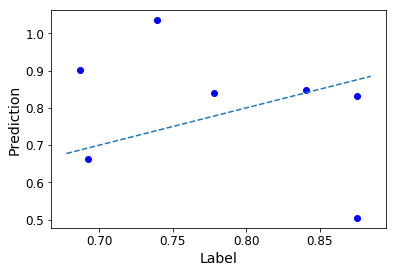

'TRAIN'


,Oxaliplatin,1,4,6,8,9,10,18,26,28,...,43,44,45,46,47,48,49,50,52,53
49,0.912904,-0.099292,-0.049921,0.093903,-0.122174,-0.037728,0.383120,0.245096,-0.558097,-0.651007,...,0.027843,-1.216677,-0.156719,-0.221017,-0.096230,0.070726,0.387022,0.176322,0.393235,-0.085440
3,0.924407,-0.494288,-0.585292,0.200625,-0.543859,-0.550807,0.602352,0.362455,0.152620,0.105762,...,-0.012848,-0.207628,0.007515,0.405350,-0.026541,0.686015,0.892808,-1.248245,0.162810,-0.071772
42,0.874615,-0.257204,-0.260530,0.335156,0.216150,0.032940,0.515540,0.407906,0.578549,0.312951,...,-0.083616,-0.389869,-0.229171,0.309309,-0.259634,0.683283,0.730139,-0.258134,0.317763,-1.008434
12,0.839335,-0.630500,-0.573515,0.092297,0.278194,-0.078141,0.649611,0.224325,-0.245483,-0.180274,...,-0.164235,-0.559933,0.368464,0.260209,-0.558487,0.542000,0.657271,0.552537,0.560688,-0.907621
7,0.858955,-0.449552,-0.292191,-0.226701,1.289295,0.528855,-0.092931,0.633048,1.162489,0.196713,...,0.115252,-0.519968,-0.366583,-0.308246,-0.316218,0.368994,0.616677,-0.981539,-0.336687,-1.463251
14,0.783065,0.081332,-0.054980,-0.070272,-1.143911,-0.040811,0.573311,0.365629,-0.255211,-0.339361,...,-0.238737,-0.401886,-0.115039,-0.541325,-0.351988,0.660885,0.782228,-0.183996,-0.123555,-0.154656
45,0.777879,-0.553356,-0.626908,0.254959,-0.440423,-0.535674,-0.103523,0.687648,0.036670,0.068482,...,-0.278365,-0.654158,-0.505110,-0.527062,-0.475028,0.744480,0.768278,-1.050224,0.290126,-0.704034
26,0.907493,0.062524,0.046054,0.230612,-0.296368,-0.423706,0.549676,0.409402,0.184092,0.724945,...,0.128059,-0.823991,-0.939748,-0.186776,-0.838846,0.362982,0.464413,0.011212,-0.541660,-1.027032
27,0.728443,0.188480,0.005245,-0.128250,0.386500,-0.021539,-0.315933,0.445162,0.192573,0.157855,...,-0.173763,0.035426,0.113798,-0.007964,-0.479805,0.533104,0.536431,-0.613951,0.321583,-0.935108
33,0.703624,-0.661236,-0.657760,0.235469,0.072571,-0.159201,0.097861,0.343506,-0.853388,0.291893,...,0.135366,-0.134136,0.136543,-0.029101,0.066422,0.817173,0.915590,-0.594891,0.545486,-0.920124


'TEST'


,Oxaliplatin,1,4,6,8,9,10,18,26,28,...,43,44,45,46,47,48,49,50,52,53
28,0.896108,0.100842,0.176792,0.286407,-0.500770,-0.515221,-0.057958,-0.161896,0.816140,0.772741,...,0.114698,-0.030854,0.048133,0.117603,0.046509,0.413547,0.446485,-0.260582,0.112955,-0.607816
48,0.866260,0.088936,-0.046715,0.288028,0.078507,0.041986,0.577174,-0.352621,0.789425,-0.595836,...,0.160846,-0.754018,-0.796073,0.056137,-0.689558,0.234045,0.594899,0.145936,0.176360,-0.872517
30,0.794773,-0.142605,-0.314467,-0.054921,-0.872900,-0.781188,0.600398,0.475794,0.177194,0.158062,...,0.094297,-0.301327,-0.127216,-0.056325,-0.154649,0.277617,0.508344,-0.670705,0.266432,-0.610304
8,0.780229,-0.031180,-0.153512,0.093899,-0.079696,-0.071165,0.345770,0.251604,-0.068857,-0.031771,...,0.017210,-0.090001,-0.039323,0.247772,-0.920805,0.035799,0.242064,0.727594,0.715756,-0.120640
54,0.823390,0.045642,-0.049498,-0.612778,-0.857374,-0.128921,-0.433573,0.446114,0.832755,0.735107,...,-0.049674,-0.375108,-0.036024,0.155403,-0.031953,0.412994,0.464774,-0.778031,0.099411,-1.069674
0,0.927028,-0.191476,-0.111982,-0.031535,0.194702,0.109698,0.003998,0.119656,0.156530,0.251035,...,-0.180308,-0.388883,-0.254426,-0.132726,-0.228261,0.044768,0.090468,0.614185,0.673407,-0.860605
43,0.893052,-0.179435,-0.093792,0.181812,0.037107,-0.077954,0.433984,0.247703,0.105836,-0.014121,...,0.005119,-0.365865,-0.190448,0.269640,-0.133813,0.179332,0.194316,0.024681,0.232569,-0.309794


array([], dtype=int64)
RMSE: 0.132656592917
Pearson: (0.37797432834150735, 0.40316705708379402)
Spearman: SpearmanrResult(correlation=0.28571428571428575, pvalue=0.53450922860104055)


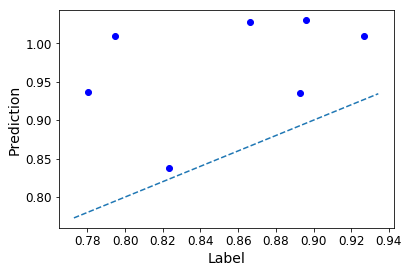

In [231]:
for label in labels:
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA, y_nonNA, test_size=0.20)
    
    display_set(X_TRAIN, X_TEST, Y_TRAIN, Y_TEST)
        
    Ypipeline, XYpipeline = retrieve_pipelines("ridge_model", Ridge(alpha = 0.8))
    
    y_test_np, y_prediction, this_y_train_tr = train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)

    rmse, r, t = simple_score(y_test_np, y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))

    #scores = cv_score(XYpipeline, X_TRAIN, this_y_train_tr)
    
    #print("CV Scores: " + str(scores))
    #print("CV Mean: " + str(scores.mean()))
    #print("CV STD: " + str(scores.std()))
             
    visualize(y_test_np, y_prediction)


### Visualize ML results using Random Forest Regressor

'TRAIN'


,Gemcitabine,1,4,6,8,9,10,18,26,28,...,43,44,45,46,47,48,49,50,52,53
30,0.636072,-0.142605,-0.314467,-0.054921,-0.872900,-0.781188,0.600398,0.475794,0.177194,0.158062,...,0.094297,-0.301327,-0.127216,-0.056325,-0.154649,0.277617,0.508344,-0.670705,0.266432,-0.610304
48,0.777284,0.088936,-0.046715,0.288028,0.078507,0.041986,0.577174,-0.352621,0.789425,-0.595836,...,0.160846,-0.754018,-0.796073,0.056137,-0.689558,0.234045,0.594899,0.145936,0.176360,-0.872517
11,0.537925,-0.254319,-0.314949,0.120570,-0.101179,0.013621,-0.299450,0.565517,0.229382,0.290038,...,-0.216381,-1.642832,0.031561,0.028808,0.105595,0.361892,0.662162,-0.441893,-0.503256,-0.778165
20,0.587329,-0.621311,-0.694679,0.410747,0.128349,0.157904,-0.253223,0.165145,0.340186,0.673163,...,0.005222,0.091789,0.242627,0.404049,0.218238,0.536810,1.076009,-0.537738,0.239328,-1.724291
7,0.719214,-0.449552,-0.292191,-0.226701,1.289295,0.528855,-0.092931,0.633048,1.162489,0.196713,...,0.115252,-0.519968,-0.366583,-0.308246,-0.316218,0.368994,0.616677,-0.981539,-0.336687,-1.463251
26,0.649721,0.062524,0.046054,0.230612,-0.296368,-0.423706,0.549676,0.409402,0.184092,0.724945,...,0.128059,-0.823991,-0.939748,-0.186776,-0.838846,0.362982,0.464413,0.011212,-0.541660,-1.027032
27,0.650505,0.188480,0.005245,-0.128250,0.386500,-0.021539,-0.315933,0.445162,0.192573,0.157855,...,-0.173763,0.035426,0.113798,-0.007964,-0.479805,0.533104,0.536431,-0.613951,0.321583,-0.935108
2,0.736595,-0.516071,-0.485236,0.178861,-0.645285,-0.570933,0.637539,0.410054,-0.315922,-0.421444,...,0.096073,-0.113105,-0.542922,0.354936,-0.478933,0.325882,0.367046,-0.324453,0.568131,-0.058653
8,0.659406,-0.031180,-0.153512,0.093899,-0.079696,-0.071165,0.345770,0.251604,-0.068857,-0.031771,...,0.017210,-0.090001,-0.039323,0.247772,-0.920805,0.035799,0.242064,0.727594,0.715756,-0.120640
24,0.710962,-0.016205,0.010176,0.196368,0.040452,0.012000,0.358982,0.097246,0.033353,0.047589,...,0.099536,-0.002248,0.068053,0.239143,0.073498,0.405691,0.383866,-0.728602,0.406252,-0.257473


'TEST'


,Gemcitabine,1,4,6,8,9,10,18,26,28,...,43,44,45,46,47,48,49,50,52,53
50,0.690240,0.029385,-0.045247,0.173001,-0.065459,-0.053373,0.402152,0.258128,0.086468,0.045436,...,0.097589,-0.155218,-0.001989,-0.035146,-0.859525,0.346353,0.392147,-0.669184,0.126944,-0.139881
9,0.588977,-0.375885,-0.477392,-0.698400,-0.005437,-0.177461,0.358437,0.324040,-0.366013,-0.328785,...,0.056420,0.151259,0.123738,0.261639,-0.356099,0.650798,0.793634,-0.745894,0.324992,-0.490552
12,0.645679,-0.630500,-0.573515,0.092297,0.278194,-0.078141,0.649611,0.224325,-0.245483,-0.180274,...,-0.164235,-0.559933,0.368464,0.260209,-0.558487,0.542000,0.657271,0.552537,0.560688,-0.907621
0,0.637520,-0.191476,-0.111982,-0.031535,0.194702,0.109698,0.003998,0.119656,0.156530,0.251035,...,-0.180308,-0.388883,-0.254426,-0.132726,-0.228261,0.044768,0.090468,0.614185,0.673407,-0.860605
3,0.672706,-0.494288,-0.585292,0.200625,-0.543859,-0.550807,0.602352,0.362455,0.152620,0.105762,...,-0.012848,-0.207628,0.007515,0.405350,-0.026541,0.686015,0.892808,-1.248245,0.162810,-0.071772
6,0.703385,-0.865086,-0.839420,0.063100,1.017900,0.767024,0.350421,0.702739,0.903873,-0.291576,...,0.047438,-1.078818,-0.244171,-0.729638,-0.165546,0.696704,0.726559,-0.631101,-0.176888,-1.077671
33,0.628506,-0.661236,-0.657760,0.235469,0.072571,-0.159201,0.097861,0.343506,-0.853388,0.291893,...,0.135366,-0.134136,0.136543,-0.029101,0.066422,0.817173,0.915590,-0.594891,0.545486,-0.920124
45,0.547590,-0.553356,-0.626908,0.254959,-0.440423,-0.535674,-0.103523,0.687648,0.036670,0.068482,...,-0.278365,-0.654158,-0.505110,-0.527062,-0.475028,0.744480,0.768278,-1.050224,0.290126,-0.704034


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.0484081373255
Pearson: (0.27350645153734959, 0.51217628883810506)
Spearman: SpearmanrResult(correlation=0.2142857142857143, pvalue=0.61034441564526687)


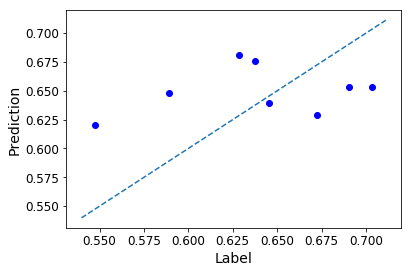

'TRAIN'


,Paclitaxel,1,4,6,8,9,10,18,26,28,...,43,44,45,46,47,48,49,50,52,53
48,0.745540,0.088936,-0.046715,0.288028,0.078507,0.041986,0.577174,-0.352621,0.789425,-0.595836,...,0.160846,-0.754018,-0.796073,0.056137,-0.689558,0.234045,0.594899,0.145936,0.176360,-0.872517
26,0.588074,0.062524,0.046054,0.230612,-0.296368,-0.423706,0.549676,0.409402,0.184092,0.724945,...,0.128059,-0.823991,-0.939748,-0.186776,-0.838846,0.362982,0.464413,0.011212,-0.541660,-1.027032
49,0.579235,-0.099292,-0.049921,0.093903,-0.122174,-0.037728,0.383120,0.245096,-0.558097,-0.651007,...,0.027843,-1.216677,-0.156719,-0.221017,-0.096230,0.070726,0.387022,0.176322,0.393235,-0.085440
4,0.614227,-0.548347,-0.512629,0.188757,-0.508282,-0.553873,0.629993,0.340205,-0.345301,-0.423682,...,0.105863,-0.005723,-0.486995,0.389744,-0.490257,0.341218,0.439575,-0.359887,0.544827,-0.097471
6,0.716384,-0.865086,-0.839420,0.063100,1.017900,0.767024,0.350421,0.702739,0.903873,-0.291576,...,0.047438,-1.078818,-0.244171,-0.729638,-0.165546,0.696704,0.726559,-0.631101,-0.176888,-1.077671
42,0.741068,-0.257204,-0.260530,0.335156,0.216150,0.032940,0.515540,0.407906,0.578549,0.312951,...,-0.083616,-0.389869,-0.229171,0.309309,-0.259634,0.683283,0.730139,-0.258134,0.317763,-1.008434
0,0.652945,-0.191476,-0.111982,-0.031535,0.194702,0.109698,0.003998,0.119656,0.156530,0.251035,...,-0.180308,-0.388883,-0.254426,-0.132726,-0.228261,0.044768,0.090468,0.614185,0.673407,-0.860605
15,0.681017,0.052958,-0.064011,0.186196,0.459753,0.011592,0.412557,0.333086,0.031534,-0.025089,...,0.104651,0.406496,0.665337,-0.620469,-0.882895,0.249471,0.392494,-0.825713,0.201539,-0.804902
14,0.519171,0.081332,-0.054980,-0.070272,-1.143911,-0.040811,0.573311,0.365629,-0.255211,-0.339361,...,-0.238737,-0.401886,-0.115039,-0.541325,-0.351988,0.660885,0.782228,-0.183996,-0.123555,-0.154656
5,0.555007,-0.152207,-0.232395,0.017240,0.090808,0.594028,0.250321,0.542556,1.071464,-0.115415,...,-0.051265,-0.982253,-0.722570,0.101296,-0.701480,0.399766,0.568611,-1.265804,-0.727523,-0.840313


'TEST'


,Paclitaxel,1,4,6,8,9,10,18,26,28,...,43,44,45,46,47,48,49,50,52,53
20,0.586244,-0.621311,-0.694679,0.410747,0.128349,0.157904,-0.253223,0.165145,0.340186,0.673163,...,0.005222,0.091789,0.242627,0.404049,0.218238,0.536810,1.076009,-0.537738,0.239328,-1.724291
30,0.567934,-0.142605,-0.314467,-0.054921,-0.872900,-0.781188,0.600398,0.475794,0.177194,0.158062,...,0.094297,-0.301327,-0.127216,-0.056325,-0.154649,0.277617,0.508344,-0.670705,0.266432,-0.610304
23,0.685397,-0.459061,-0.470274,0.149253,-0.115348,0.355631,-0.046983,0.798941,-0.386431,-0.434430,...,-0.448763,-0.711446,-0.649702,-0.309415,-0.550822,-0.206520,-0.121337,0.931852,0.885218,-0.717596
28,0.666951,0.100842,0.176792,0.286407,-0.500770,-0.515221,-0.057958,-0.161896,0.816140,0.772741,...,0.114698,-0.030854,0.048133,0.117603,0.046509,0.413547,0.446485,-0.260582,0.112955,-0.607816
31,0.826007,-0.793647,-0.733394,-0.577410,0.131569,0.173874,0.508716,0.358452,-0.538476,-0.545914,...,-0.498442,-0.013938,0.098197,0.044226,0.153715,0.607891,0.504616,-0.547103,0.266265,-0.871054
45,0.589626,-0.553356,-0.626908,0.254959,-0.440423,-0.535674,-0.103523,0.687648,0.036670,0.068482,...,-0.278365,-0.654158,-0.505110,-0.527062,-0.475028,0.744480,0.768278,-1.050224,0.290126,-0.704034
27,0.518664,0.188480,0.005245,-0.128250,0.386500,-0.021539,-0.315933,0.445162,0.192573,0.157855,...,-0.173763,0.035426,0.113798,-0.007964,-0.479805,0.533104,0.536431,-0.613951,0.321583,-0.935108
12,0.630910,-0.630500,-0.573515,0.092297,0.278194,-0.078141,0.649611,0.224325,-0.245483,-0.180274,...,-0.164235,-0.559933,0.368464,0.260209,-0.558487,0.542000,0.657271,0.552537,0.560688,-0.907621


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.0974819619074
Pearson: (-0.22233639176219025, 0.59665409631461652)
Spearman: SpearmanrResult(correlation=-0.16666666666666671, pvalue=0.69323881172839497)


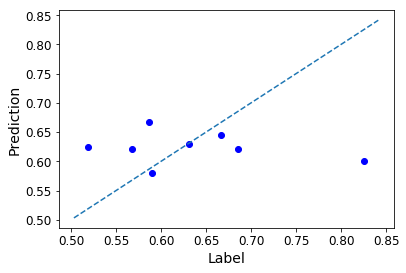

'TRAIN'


,SN-38,1,4,6,8,9,10,18,26,28,...,43,44,45,46,47,48,49,50,52,53
23,0.583725,-0.459061,-0.470274,0.149253,-0.115348,0.355631,-0.046983,0.798941,-0.386431,-0.434430,...,-0.448763,-0.711446,-0.649702,-0.309415,-0.550822,-0.206520,-0.121337,0.931852,0.885218,-0.717596
2,0.606223,-0.516071,-0.485236,0.178861,-0.645285,-0.570933,0.637539,0.410054,-0.315922,-0.421444,...,0.096073,-0.113105,-0.542922,0.354936,-0.478933,0.325882,0.367046,-0.324453,0.568131,-0.058653
41,0.635591,-0.230522,-0.308004,-0.456408,-0.188917,0.259390,0.197161,0.055987,0.244007,-0.135973,...,0.418812,-0.201626,-0.055673,0.208578,-0.083814,0.397680,0.308472,-0.202924,0.322068,-0.705301
32,0.548900,-0.292889,-0.282393,0.263494,0.936464,-0.367825,0.502159,-0.044175,0.183044,0.217955,...,-0.280216,-0.355018,-0.311647,0.018024,-0.301959,0.755412,0.965802,-0.152294,0.737134,-0.305370
54,0.530075,0.045642,-0.049498,-0.612778,-0.857374,-0.128921,-0.433573,0.446114,0.832755,0.735107,...,-0.049674,-0.375108,-0.036024,0.155403,-0.031953,0.412994,0.464774,-0.778031,0.099411,-1.069674
49,0.586283,-0.099292,-0.049921,0.093903,-0.122174,-0.037728,0.383120,0.245096,-0.558097,-0.651007,...,0.027843,-1.216677,-0.156719,-0.221017,-0.096230,0.070726,0.387022,0.176322,0.393235,-0.085440
9,0.610205,-0.375885,-0.477392,-0.698400,-0.005437,-0.177461,0.358437,0.324040,-0.366013,-0.328785,...,0.056420,0.151259,0.123738,0.261639,-0.356099,0.650798,0.793634,-0.745894,0.324992,-0.490552
5,0.577066,-0.152207,-0.232395,0.017240,0.090808,0.594028,0.250321,0.542556,1.071464,-0.115415,...,-0.051265,-0.982253,-0.722570,0.101296,-0.701480,0.399766,0.568611,-1.265804,-0.727523,-0.840313
46,0.576028,-0.132991,-0.052921,0.159445,0.455027,-0.089800,0.279075,0.183969,-0.065135,-0.069582,...,-0.009625,-1.046767,-0.962740,-0.198716,-0.983554,0.260043,0.295669,0.130036,0.109968,-0.250841
50,0.610227,0.029385,-0.045247,0.173001,-0.065459,-0.053373,0.402152,0.258128,0.086468,0.045436,...,0.097589,-0.155218,-0.001989,-0.035146,-0.859525,0.346353,0.392147,-0.669184,0.126944,-0.139881


'TEST'


,SN-38,1,4,6,8,9,10,18,26,28,...,43,44,45,46,47,48,49,50,52,53
29,0.554903,-0.064291,0.008584,0.135002,0.002919,-0.987501,0.361297,0.257853,0.043798,0.022232,...,0.070613,0.356154,0.523368,0.375216,-0.922260,0.345536,0.247239,-0.338829,0.203672,-0.188640
43,0.646083,-0.179435,-0.093792,0.181812,0.037107,-0.077954,0.433984,0.247703,0.105836,-0.014121,...,0.005119,-0.365865,-0.190448,0.269640,-0.133813,0.179332,0.194316,0.024681,0.232569,-0.309794
0,0.679371,-0.191476,-0.111982,-0.031535,0.194702,0.109698,0.003998,0.119656,0.156530,0.251035,...,-0.180308,-0.388883,-0.254426,-0.132726,-0.228261,0.044768,0.090468,0.614185,0.673407,-0.860605
26,0.647026,0.062524,0.046054,0.230612,-0.296368,-0.423706,0.549676,0.409402,0.184092,0.724945,...,0.128059,-0.823991,-0.939748,-0.186776,-0.838846,0.362982,0.464413,0.011212,-0.541660,-1.027032
3,0.590799,-0.494288,-0.585292,0.200625,-0.543859,-0.550807,0.602352,0.362455,0.152620,0.105762,...,-0.012848,-0.207628,0.007515,0.405350,-0.026541,0.686015,0.892808,-1.248245,0.162810,-0.071772
14,0.564607,0.081332,-0.054980,-0.070272,-1.143911,-0.040811,0.573311,0.365629,-0.255211,-0.339361,...,-0.238737,-0.401886,-0.115039,-0.541325,-0.351988,0.660885,0.782228,-0.183996,-0.123555,-0.154656
7,0.685489,-0.449552,-0.292191,-0.226701,1.289295,0.528855,-0.092931,0.633048,1.162489,0.196713,...,0.115252,-0.519968,-0.366583,-0.308246,-0.316218,0.368994,0.616677,-0.981539,-0.336687,-1.463251
12,0.682710,-0.630500,-0.573515,0.092297,0.278194,-0.078141,0.649611,0.224325,-0.245483,-0.180274,...,-0.164235,-0.559933,0.368464,0.260209,-0.558487,0.542000,0.657271,0.552537,0.560688,-0.907621


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.0657585867581
Pearson: (-0.31067883830437193, 0.45387570109579028)
Spearman: SpearmanrResult(correlation=0.095238095238095261, pvalue=0.82250543020361144)


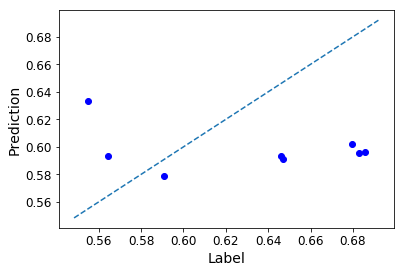

'TRAIN'


,5-FU,1,4,6,8,9,10,18,26,28,...,43,44,45,46,47,48,49,50,52,53
49,0.739124,-0.099292,-0.049921,0.093903,-0.122174,-0.037728,0.383120,0.245096,-0.558097,-0.651007,...,0.027843,-1.216677,-0.156719,-0.221017,-0.096230,0.070726,0.387022,0.176322,0.393235,-0.085440
2,0.909020,-0.516071,-0.485236,0.178861,-0.645285,-0.570933,0.637539,0.410054,-0.315922,-0.421444,...,0.096073,-0.113105,-0.542922,0.354936,-0.478933,0.325882,0.367046,-0.324453,0.568131,-0.058653
54,0.847659,0.045642,-0.049498,-0.612778,-0.857374,-0.128921,-0.433573,0.446114,0.832755,0.735107,...,-0.049674,-0.375108,-0.036024,0.155403,-0.031953,0.412994,0.464774,-0.778031,0.099411,-1.069674
14,0.799785,0.081332,-0.054980,-0.070272,-1.143911,-0.040811,0.573311,0.365629,-0.255211,-0.339361,...,-0.238737,-0.401886,-0.115039,-0.541325,-0.351988,0.660885,0.782228,-0.183996,-0.123555,-0.154656
27,0.643765,0.188480,0.005245,-0.128250,0.386500,-0.021539,-0.315933,0.445162,0.192573,0.157855,...,-0.173763,0.035426,0.113798,-0.007964,-0.479805,0.533104,0.536431,-0.613951,0.321583,-0.935108
5,0.655291,-0.152207,-0.232395,0.017240,0.090808,0.594028,0.250321,0.542556,1.071464,-0.115415,...,-0.051265,-0.982253,-0.722570,0.101296,-0.701480,0.399766,0.568611,-1.265804,-0.727523,-0.840313
11,0.845183,-0.254319,-0.314949,0.120570,-0.101179,0.013621,-0.299450,0.565517,0.229382,0.290038,...,-0.216381,-1.642832,0.031561,0.028808,0.105595,0.361892,0.662162,-0.441893,-0.503256,-0.778165
12,0.942370,-0.630500,-0.573515,0.092297,0.278194,-0.078141,0.649611,0.224325,-0.245483,-0.180274,...,-0.164235,-0.559933,0.368464,0.260209,-0.558487,0.542000,0.657271,0.552537,0.560688,-0.907621
16,0.726636,0.069205,-0.100637,0.231349,-0.121998,-0.077860,0.563741,0.374175,-0.770149,-0.829023,...,-0.402500,-0.106846,-0.010322,-0.059411,-0.044529,0.313438,0.491236,0.135857,0.180003,-1.132962
7,0.833724,-0.449552,-0.292191,-0.226701,1.289295,0.528855,-0.092931,0.633048,1.162489,0.196713,...,0.115252,-0.519968,-0.366583,-0.308246,-0.316218,0.368994,0.616677,-0.981539,-0.336687,-1.463251


'TEST'


,5-FU,1,4,6,8,9,10,18,26,28,...,43,44,45,46,47,48,49,50,52,53
28,0.874941,0.100842,0.176792,0.286407,-0.500770,-0.515221,-0.057958,-0.161896,0.816140,0.772741,...,0.114698,-0.030854,0.048133,0.117603,0.046509,0.413547,0.446485,-0.260582,0.112955,-0.607816
43,0.836726,-0.179435,-0.093792,0.181812,0.037107,-0.077954,0.433984,0.247703,0.105836,-0.014121,...,0.005119,-0.365865,-0.190448,0.269640,-0.133813,0.179332,0.194316,0.024681,0.232569,-0.309794
48,0.924357,0.088936,-0.046715,0.288028,0.078507,0.041986,0.577174,-0.352621,0.789425,-0.595836,...,0.160846,-0.754018,-0.796073,0.056137,-0.689558,0.234045,0.594899,0.145936,0.176360,-0.872517
24,0.881464,-0.016205,0.010176,0.196368,0.040452,0.012000,0.358982,0.097246,0.033353,0.047589,...,0.099536,-0.002248,0.068053,0.239143,0.073498,0.405691,0.383866,-0.728602,0.406252,-0.257473
32,0.794304,-0.292889,-0.282393,0.263494,0.936464,-0.367825,0.502159,-0.044175,0.183044,0.217955,...,-0.280216,-0.355018,-0.311647,0.018024,-0.301959,0.755412,0.965802,-0.152294,0.737134,-0.305370
4,0.583491,-0.548347,-0.512629,0.188757,-0.508282,-0.553873,0.629993,0.340205,-0.345301,-0.423682,...,0.105863,-0.005723,-0.486995,0.389744,-0.490257,0.341218,0.439575,-0.359887,0.544827,-0.097471
9,0.692301,-0.375885,-0.477392,-0.698400,-0.005437,-0.177461,0.358437,0.324040,-0.366013,-0.328785,...,0.056420,0.151259,0.123738,0.261639,-0.356099,0.650798,0.793634,-0.745894,0.324992,-0.490552


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.126864512017
Pearson: (-0.15290071507056902, 0.74345123638532906)
Spearman: SpearmanrResult(correlation=0.0, pvalue=1.0)


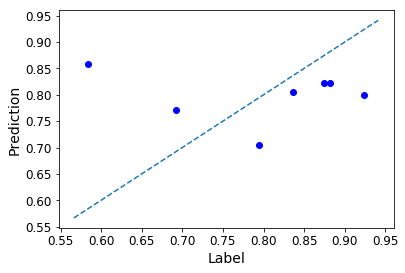

'TRAIN'


,Oxaliplatin,1,4,6,8,9,10,18,26,28,...,43,44,45,46,47,48,49,50,52,53
32,0.914314,-0.292889,-0.282393,0.263494,0.936464,-0.367825,0.502159,-0.044175,0.183044,0.217955,...,-0.280216,-0.355018,-0.311647,0.018024,-0.301959,0.755412,0.965802,-0.152294,0.737134,-0.305370
45,0.777879,-0.553356,-0.626908,0.254959,-0.440423,-0.535674,-0.103523,0.687648,0.036670,0.068482,...,-0.278365,-0.654158,-0.505110,-0.527062,-0.475028,0.744480,0.768278,-1.050224,0.290126,-0.704034
12,0.839335,-0.630500,-0.573515,0.092297,0.278194,-0.078141,0.649611,0.224325,-0.245483,-0.180274,...,-0.164235,-0.559933,0.368464,0.260209,-0.558487,0.542000,0.657271,0.552537,0.560688,-0.907621
33,0.703624,-0.661236,-0.657760,0.235469,0.072571,-0.159201,0.097861,0.343506,-0.853388,0.291893,...,0.135366,-0.134136,0.136543,-0.029101,0.066422,0.817173,0.915590,-0.594891,0.545486,-0.920124
24,0.919577,-0.016205,0.010176,0.196368,0.040452,0.012000,0.358982,0.097246,0.033353,0.047589,...,0.099536,-0.002248,0.068053,0.239143,0.073498,0.405691,0.383866,-0.728602,0.406252,-0.257473
25,0.967485,-0.013634,-0.128379,1.534339,0.393781,-0.042226,-0.599865,0.393313,0.304675,0.360463,...,0.028420,-0.167471,-0.017666,0.187767,0.017105,-0.005599,0.423871,-0.749673,0.202488,-0.817535
42,0.874615,-0.257204,-0.260530,0.335156,0.216150,0.032940,0.515540,0.407906,0.578549,0.312951,...,-0.083616,-0.389869,-0.229171,0.309309,-0.259634,0.683283,0.730139,-0.258134,0.317763,-1.008434
16,0.746754,0.069205,-0.100637,0.231349,-0.121998,-0.077860,0.563741,0.374175,-0.770149,-0.829023,...,-0.402500,-0.106846,-0.010322,-0.059411,-0.044529,0.313438,0.491236,0.135857,0.180003,-1.132962
11,0.740179,-0.254319,-0.314949,0.120570,-0.101179,0.013621,-0.299450,0.565517,0.229382,0.290038,...,-0.216381,-1.642832,0.031561,0.028808,0.105595,0.361892,0.662162,-0.441893,-0.503256,-0.778165
2,0.939280,-0.516071,-0.485236,0.178861,-0.645285,-0.570933,0.637539,0.410054,-0.315922,-0.421444,...,0.096073,-0.113105,-0.542922,0.354936,-0.478933,0.325882,0.367046,-0.324453,0.568131,-0.058653


'TEST'


,Oxaliplatin,1,4,6,8,9,10,18,26,28,...,43,44,45,46,47,48,49,50,52,53
29,0.791185,-0.064291,0.008584,0.135002,0.002919,-0.987501,0.361297,0.257853,0.043798,0.022232,...,0.070613,0.356154,0.523368,0.375216,-0.922260,0.345536,0.247239,-0.338829,0.203672,-0.188640
30,0.794773,-0.142605,-0.314467,-0.054921,-0.872900,-0.781188,0.600398,0.475794,0.177194,0.158062,...,0.094297,-0.301327,-0.127216,-0.056325,-0.154649,0.277617,0.508344,-0.670705,0.266432,-0.610304
7,0.858955,-0.449552,-0.292191,-0.226701,1.289295,0.528855,-0.092931,0.633048,1.162489,0.196713,...,0.115252,-0.519968,-0.366583,-0.308246,-0.316218,0.368994,0.616677,-0.981539,-0.336687,-1.463251
6,0.755721,-0.865086,-0.839420,0.063100,1.017900,0.767024,0.350421,0.702739,0.903873,-0.291576,...,0.047438,-1.078818,-0.244171,-0.729638,-0.165546,0.696704,0.726559,-0.631101,-0.176888,-1.077671
0,0.927028,-0.191476,-0.111982,-0.031535,0.194702,0.109698,0.003998,0.119656,0.156530,0.251035,...,-0.180308,-0.388883,-0.254426,-0.132726,-0.228261,0.044768,0.090468,0.614185,0.673407,-0.860605
49,0.912904,-0.099292,-0.049921,0.093903,-0.122174,-0.037728,0.383120,0.245096,-0.558097,-0.651007,...,0.027843,-1.216677,-0.156719,-0.221017,-0.096230,0.070726,0.387022,0.176322,0.393235,-0.085440
50,0.846689,0.029385,-0.045247,0.173001,-0.065459,-0.053373,0.402152,0.258128,0.086468,0.045436,...,0.097589,-0.155218,-0.001989,-0.035146,-0.859525,0.346353,0.392147,-0.669184,0.126944,-0.139881


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.0748568930764
Pearson: (-0.47150885727009445, 0.28546945439469734)
Spearman: SpearmanrResult(correlation=-0.35714285714285721, pvalue=0.43161135203832779)


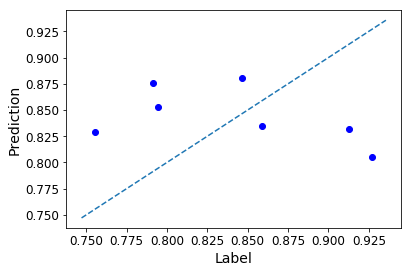

In [248]:
for label in labels:
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA, y_nonNA, test_size=0.20)
    
    display_set(X_TRAIN, X_TEST, Y_TRAIN, Y_TEST)
        
    Ypipeline, XYpipeline = retrieve_pipelines("rfs_model", RandomForestRegressor(n_estimators=1000, max_leaf_nodes=8, n_jobs=4))
    
    y_test_np, y_prediction, this_y_train_tr = train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)

    rmse, r, t = simple_score(y_test_np, y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))

    #scores = cv_score(XYpipeline, X_TRAIN, this_y_train_tr)
    
    #print("CV Scores: " + str(scores))
    #print("CV Mean: " + str(scores.mean()))
    #print("CV STD: " + str(scores.std()))
             
    visualize(y_test_np, y_prediction)


### Bootstrap Regression Model

RMSE: 0.105287063638
Pearson: (0.20988224997140698, 0.076809155762405934)
Spearman: SpearmanrResult(correlation=0.23313924642349104, pvalue=0.048737559451668654)


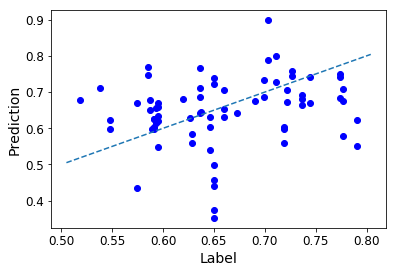

RMSE: 0.108108528397
Pearson: (0.21954871698892595, 0.063881370454916403)
Spearman: SpearmanrResult(correlation=0.20546242110422616, pvalue=0.083377063144706748)


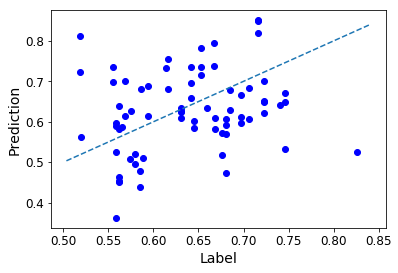

RMSE: 0.105781878987
Pearson: (0.17577214995893975, 0.13970285004115346)
Spearman: SpearmanrResult(correlation=0.14031958111602733, pvalue=0.23973870706860789)


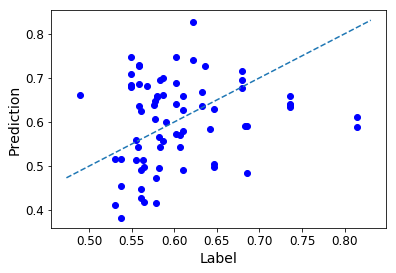

RMSE: 0.148130517683
Pearson: (0.16099273702141118, 0.20749175078818088)
Spearman: SpearmanrResult(correlation=0.095281581279814384, pvalue=0.45758934316454714)


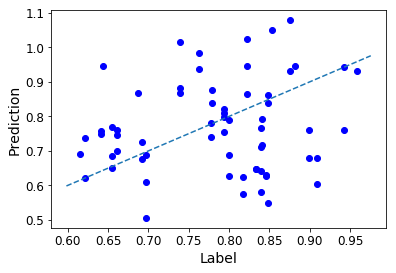

RMSE: 0.1306657069
Pearson: (-0.037620432889420879, 0.76973079187760096)
Spearman: SpearmanrResult(correlation=-0.0085249456040179944, pvalue=0.94713034214201142)


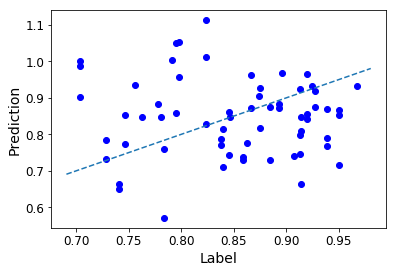

In [256]:
for label in labels:
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    
    all_y_test_np = np.array([])
    all_y_prediction = np.array([])
    for i in range(1,10):
        X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA, y_nonNA, test_size=0.20)

        Ypipeline, XYpipeline = retrieve_pipelines("ridge_model", Ridge(alpha = 0.80))

        y_test_np, y_prediction, _ = train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)
        all_y_test_np = np.append(all_y_test_np, y_test_np)
        all_y_prediction = np.append(all_y_prediction, y_prediction)
        
    rmse, r, t = simple_score(all_y_test_np, all_y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))
    visualize(all_y_test_np, all_y_prediction)


### Bootstrap Random Forest Model

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0661192614118
Pearson: (0.15123368430051648, 0.37861129083178591)
Spearman: SpearmanrResult(correlation=0.12471019249374674, pvalue=0.46864208758921633)


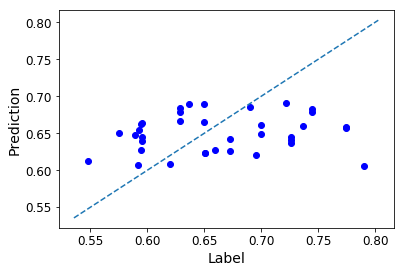

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0677158564692
Pearson: (0.15410425933830429, 0.36952100460359405)
Spearman: SpearmanrResult(correlation=0.25307844687955783, pvalue=0.13642241509817191)


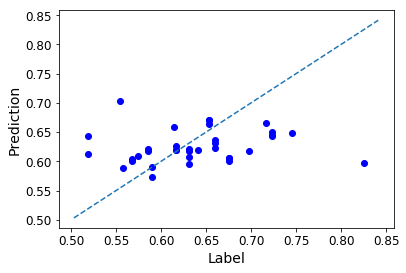

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0885138630394
Pearson: (-0.37538981257040815, 0.024066230290709811)
Spearman: SpearmanrResult(correlation=-0.32469747530748239, pvalue=0.053341735283923851)


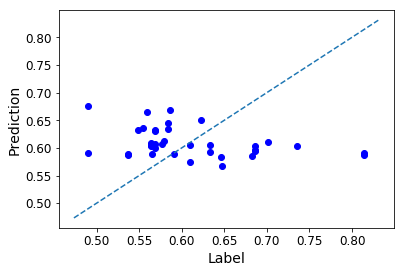

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.114237384128
Pearson: (-0.14886373459682761, 0.38621436279490418)
Spearman: SpearmanrResult(correlation=-0.13262942784261389, pvalue=0.44064284159298905)


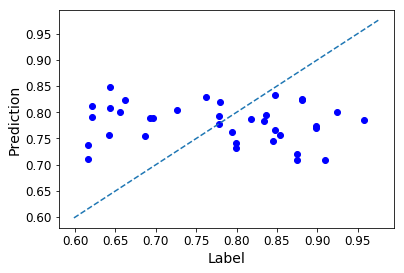

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0735247300967
Pearson: (0.11525362299155507, 0.50327049090538434)
Spearman: SpearmanrResult(correlation=0.11931460155024985, pvalue=0.48824375104050544)


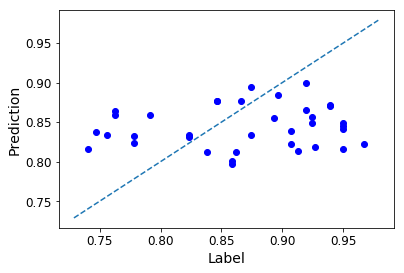

In [249]:
for label in labels:
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    
    all_y_test_np = np.array([])
    all_y_prediction = np.array([])
    for i in range(1,10):
        X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA, y_nonNA, test_size=0.10)

        Ypipeline, XYpipeline = retrieve_pipelines("rfs_model", RandomForestRegressor(n_estimators=1000, max_leaf_nodes=8, n_jobs=4))

        y_test_np, y_prediction, _ = train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)
        all_y_test_np = np.append(all_y_test_np, y_test_np)
        all_y_prediction = np.append(all_y_prediction, y_prediction)
        
    rmse, r, t = simple_score(all_y_test_np, all_y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))
    visualize(all_y_test_np, all_y_prediction)
